In [1]:
import detectron2
from drone_detector.imports import *

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader, build_detection_train_loader, DatasetMapper

from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
import torch

from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer

from detectron2.evaluation import COCOEvaluator, DatasetEvaluators
import cv2
import matplotlib.pyplot as plt
import wandb

from drone_detector.engines.detectron2.augmentations import *

# Model training

We used Mask R-CNN with a several pretrained backbones as our model, and fine-tuned the model with our remote sensing data. Because the convolutional layers of a CNN model extract interesting, useful features from the images, it is possible and advisable to use pretrained weights as a baseline and fine-tune the model with custom data. All models were trained for 3000 iterations with a batch size of 8, and validation metrics were recorded every 100 iterations. We used a base learning rate of 0.001 and linear warmup with cosine annealing as the learning rate scheduler, using 1000 iterations for the warmup phase. 

In [2]:
outpath = Path('../../data/processed/hiidenportti/')
register_coco_instances('hiidenportti_train', {}, outpath/'hiidenportti_train.json', outpath/'train_512')
register_coco_instances('hiidenportti_val', {}, outpath/'hiidenportti_valid.json', outpath/'valid_512')

In [3]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("hiidenportti_train",)
cfg.DATASETS.TEST = ("hiidenportti_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.TEST.EVAL_PERIOD = 100
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.OUTPUT_DIR = 'detectron2_models/mask_rcnn_R_50_FPN_3x_256'

cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 3000 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [4]:
class Trainer(DefaultTrainer):
    """
    Trainer class for training detectron2 models
    """
    
    def __init__(self, cfg):
        super().__init__(cfg)
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return DatasetEvaluators([COCOEvaluator(dataset_name, output_dir=output_folder)])
    
    @classmethod
    def build_train_loader(cls, cfg):
        augs = build_aug_transforms(cfg,
                                    flip_horiz=True,
                                    flip_vert=True,
                                    max_rotate=10,
                                    brightness_limits=(.8,1.4),
                                    contrast_limits=(.8,1.4),
                                    saturation_limits=(.8,1.4),
                                    p_lighting=0.75)
        return build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, is_train=True, augmentations=augs))

In order to effectively increase the amount of our training data, we applied a set of augmentations to our image patches and masks. First, each image was randomly flipped and randomly rotated up to 90 degrees. These geometric transformations were applied to both masks and image patches. In addition, brightness and contrast of the image were randomly adjusted and images had a chance to be slightly blurred. Each of these individual augmentations had a probability of 0.5 to be applied. 

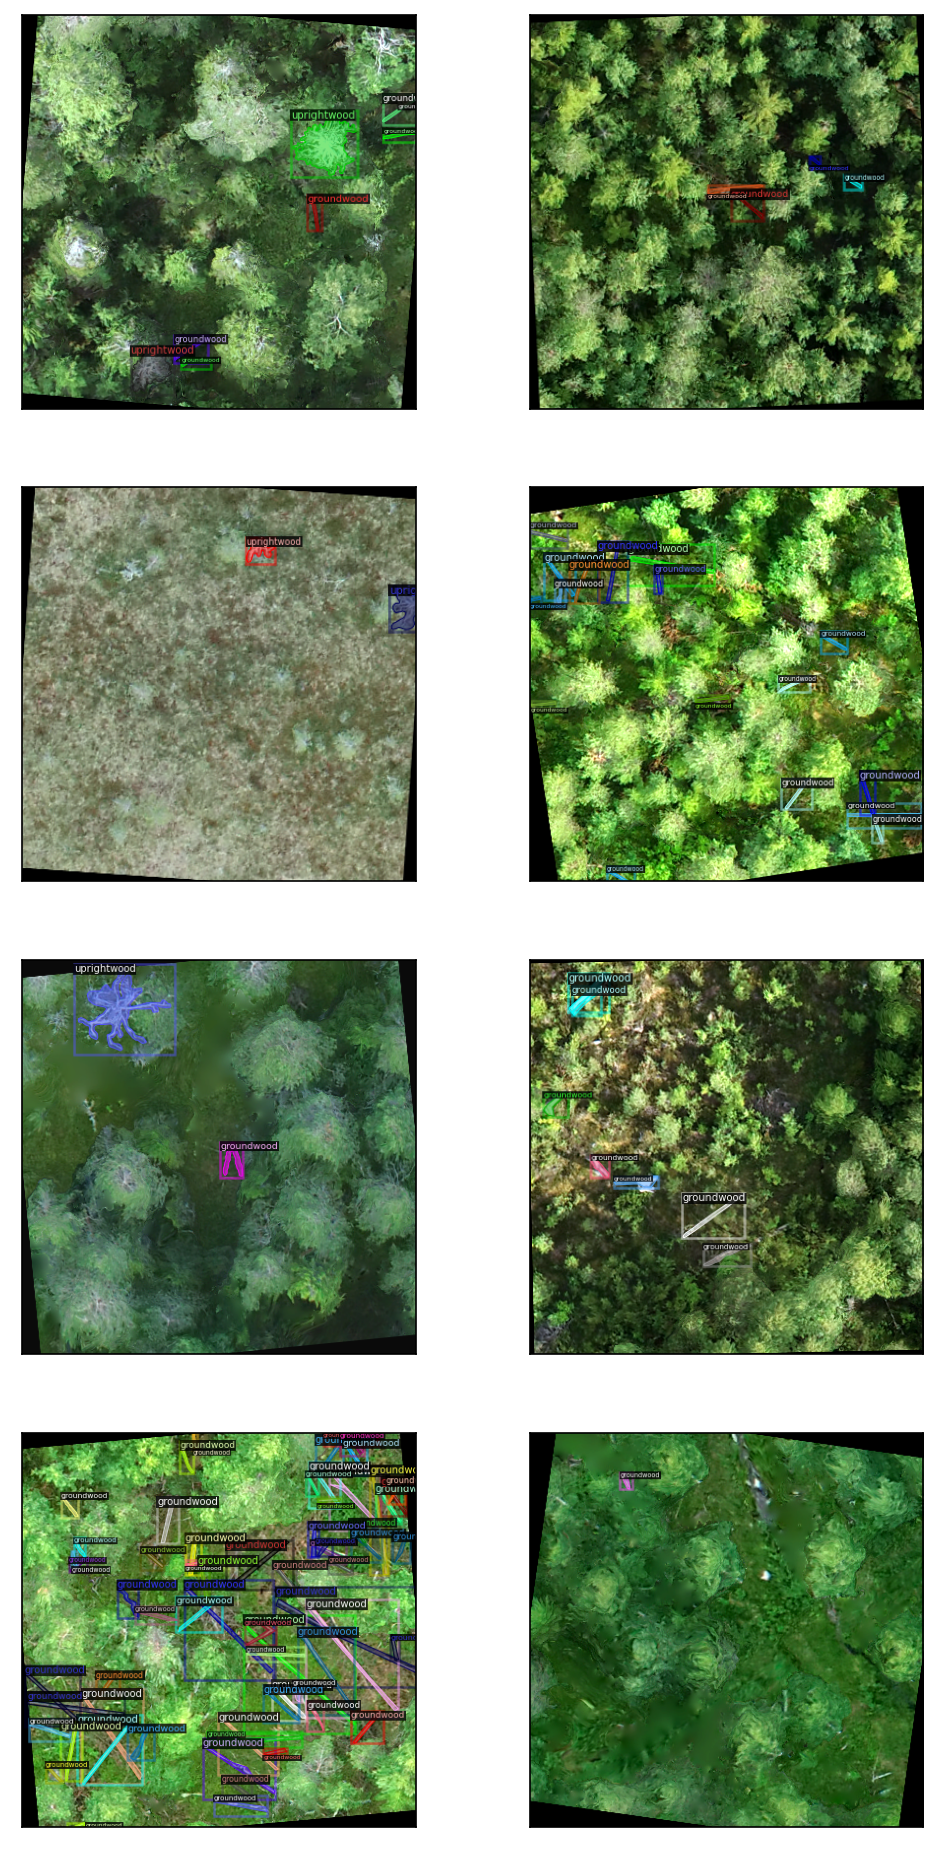

In [6]:
fig, axs = plt.subplots(4,2, figsize=(8,16), dpi=150)
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
dls = iter(build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, is_train=True, 
                                                                  augmentations=build_aug_transforms(cfg))))
batch = next(dls)
for d, ax in zip(batch, axs.flatten()):
    ax.set_xticks([])
    ax.set_yticks([])
    img = d['image'].permute(1,2,0).cpu().detach().numpy()
    img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)
    visualizer = Visualizer(img, metadata=metadata, scale=0.5)
    target_fields = d["instances"].get_fields()
    labels = [metadata.thing_classes[i] for i in target_fields["gt_classes"]]
    vis = visualizer.overlay_instances(
        labels=labels,
        boxes=target_fields.get("gt_boxes", None),
        masks=target_fields.get("gt_masks", None),
        keypoints=target_fields.get("gt_keypoints", None),
    )
    ax.imshow(vis.get_image())

All models were trained with Python version 3.9.5 using deep learning stack containing version PyTorch 1.10.1 and Detectron2 detection and segmentation library. Weights & Biases was used to track the model metrics. We used a single NVIDIA V100 GPU with 32GB of memory, hosted on computing nodes of Puhti supercomputer hosted by CSC -- IT Center for Science, Finland.

The following is for the example, all models were trained as batch jobs. First initialize wandb login.

In [8]:
#| output: false

import yaml
wandb.login()
cfg_wandb = yaml.safe_load(cfg.dump())
wandb.init(project='hiidenportti-deadwood', 
           name='test',
           sync_tensorboard=True, 
           config=cfg_wandb)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Then make the Trainer.

In [9]:
#| output: false

trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)


[02/03 15:12:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

Train the model.

In [10]:
#| output: false

trainer.train()

[02/03 15:12:58 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/opt/conda/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/03 15:13:09 d2.utils.events]:  eta: 0:26:22  iter: 19  total_loss: 3.208  loss_cls: 1.193  loss_box_reg: 0.07951  loss_mask: 0.6917  loss_rpn_cls: 1.11  loss_rpn_loc: 0.09834  time: 0.5310  data_time: 0.0635  lr: 1.5231e-05  max_mem: 5841M
[02/03 15:13:20 d2.utils.events]:  eta: 0:26:38  iter: 39  total_loss: 2.492  loss_cls: 0.7317  loss_box_reg: 0.09876  loss_mask: 0.676  loss_rpn_cls: 0.9203  loss_rpn_loc: 0.1063  time: 0.5393  data_time: 0.0297  lr: 3.0211e-05  max_mem: 5841M
[02/03 15:13:31 d2.utils.events]:  eta: 0:26:55  iter: 59  total_loss: 1.726  loss_cls: 0.4018  loss_box_reg: 0.1221  loss_mask: 0.6402  loss_rpn_cls: 0.4305  loss_rpn_loc: 0.07962  time: 0.5467  data_time: 0.0271  lr: 4.5191e-05  max_mem: 5841M
[02/03 15:13:43 d2.utils.events]:  eta: 0:26:48  iter: 79  total_loss: 1.446  loss_cls: 0.2986  loss_box_reg: 0.1998  loss_mask: 0.5795  loss_rpn_cls: 0.2444  loss_rpn_loc: 0.1048  time: 0.5527  data_time: 0.0266  lr: 6.0171e-05  max_mem: 5922M
[02/03 15:13:54 d2.d

And finish wandb.

In [11]:
#| output: false

with open(os.path.join(cfg.OUTPUT_DIR, 'config.yaml'), 'w') as f:
    f.write(cfg.dump())
    
wandb.finish()

bbox/AP,▁▃▃▄▅▅▆▆▆▇▇▇▇▇▇██████████████
bbox/AP-groundwood,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇██████████████
bbox/AP-uprightwood,▁▁▁▁▃▄▅▆▆▇▇▇▆█▇███▇█▇████████
bbox/AP50,▁▃▃▄▅▆▇▇▇▇▇▇▇▇███████████████
bbox/AP75,▁▃▃▄▄▅▆▆▆▇▇▆▆▇▇██▇▇█▇█▇██████
bbox/APm,▁▁▁▁▃▄▅▅▅▇▇▆▆█▇██████████████
bbox/APs,▁▃▄▄▅▆▆▇▇█▇▇▇████████████████
data_time,▇▂▁▄▂▁▃▃▅▃█▂▁▄▂█▇▁▁▂▁▆▅▁▅▃▅█▆▁▁▁▅▇▅▁▆▃▅▃
eta_seconds,█████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
fast_rcnn/cls_accuracy,██▄▁▅▆▆▇▅▆▆▆▆▆▆▅▇▇▆▇▇▇▇▅▆█▇▇█▇▆▅▆▇▆▆▅▇▇▇
fast_rcnn/false_negative,████▅▅▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁
